# Introduction

We are going to compare blazeface, mtcnn, and Mobilenet Face Extractor(I will call it mobilenet for the rest of this kernel). For this kernel, I am going to take only the most confident face bbox detected from the first frame.

BlazeFace helper funciton taken from [link](https://www.kaggle.com/basharallabadi/yolov2-vs-faced-vs-blazeface-vs-mtcnn), 

mtcnn code taken from [link](https://github.com/ipazc/mtcnn), 

mobilenet code/weights taken from [link](https://github.com/yeephycho/tensorflow-face-detection)

yolo code taken from [link](https://www.kaggle.com/basharallabadi/yolov2-vs-faced-vs-blazeface-vs-mtcnn)

**Here is the helper code for this face extractor(clean version)[link](https://www.kaggle.com/unkownhihi/mobilenet-face-extractor-helper-code)**

# Imports

In [61]:
import sys
import torch
import matplotlib.pyplot as plt
import cv2
import time
import tensorflow as tf
import numpy as np
import math
sys.path.insert(0, "/kaggle/input/blazeface-pytorch")

from blazeface import BlazeFace

# Initialize BlazeFace

In [62]:
blazeface = BlazeFace()
blazeface.load_weights("/kaggle/input/blazeface-pytorch/blazeface.pth")
blazeface.load_anchors("/kaggle/input/blazeface-pytorch/anchors.npy")

# Optionally change the thresholds:
blazeface.min_score_thresh = 0.75
blazeface.min_suppression_threshold = 0.3

In [63]:
def get_blaze_boxes(detections, with_keypoints=False):
    result = []
    if isinstance(detections, torch.Tensor):
        detections = detections.cpu().numpy()

    if detections.ndim == 1:
        detections = np.expand_dims(detections, axis=0)

    img_shape = (128, 128)
    for i in range(detections.shape[0]):
        ymin = detections[i, 0] * img_shape[0]
        xmin = detections[i, 1] * img_shape[1]
        ymax = detections[i, 2] * img_shape[0]
        xmax = detections[i, 3] * img_shape[1]
        result.append((xmin, ymin, xmax, ymax))
    return result
def scale_boxes(boxes, scale_w, scale_h):
    sb = []
    for b in boxes:
        sb.append((b[0] * scale_w, b[1] * scale_h, b[2] * scale_w, b[3] * scale_h))
    return sb

# Initialize Yolo

是基于mobilenetv2的yolo

In [64]:
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
def load_mobilenetv2_224_075_detector(path):
    input_tensor = Input(shape=(224, 224, 3))
    output_tensor = MobileNetV2(weights=None, include_top=False, input_tensor=input_tensor, alpha=0.75).output
    #宽度因子α是一个属于(0,1]之间的数，按比例减少通道数，目的是为了减少计算量
    output_tensor = ZeroPadding2D()(output_tensor)
    #零填充（Zero-padding）:在输入矩阵的边缘使用零值进行填充，这样我们就可以对输入图像矩阵的边缘进行滤波。零填充的一大好处是可以让我们控制特征图的大小
    output_tensor = Conv2D(kernel_size=(3, 3), filters=5)(output_tensor)
    #Conv2d 2维卷积层。filters：卷积过滤器的数量,对应输出的维数--卷积核的数目（即输出的维度）

    model = Model(inputs=input_tensor, outputs=output_tensor)
    model.load_weights(path)
    
    return model

In [65]:
mobilenetv2 = load_mobilenetv2_224_075_detector("../input/facedetection-mobilenetv2/facedetection-mobilenetv2-size224-alpha0.75.h5")

In [66]:
def transpose_shots(shots):
    return [(shot[1], shot[0], shot[3], shot[2], shot[4]) for shot in shots]

#这个常数描述的是16:9的图像
SHOTS = {
    # fast less accurate
    '2-16/9' : {
        'aspect_ratio' : 16/9,
        #显示比例
        'shots' : [
             (0, 0, 9/16, 1, 1),
             (7/16, 0, 9/16, 1, 1)
        ]
    },
    # slower more accurate
    '10-16/9' : {
        'aspect_ratio' : 16/9,
        'shots' : [
             (0, 0, 9/16, 1, 1),
             (7/16, 0, 9/16, 1, 1),
             (0, 0, 5/16, 5/9, 0.5),
             (0, 4/9, 5/16, 5/9, 0.5),
             (11/48, 0, 5/16, 5/9, 0.5),
             (11/48, 4/9, 5/16, 5/9, 0.5),
             (22/48, 0, 5/16, 5/9, 0.5),
             (22/48, 4/9, 5/16, 5/9, 0.5),
             (11/16, 0, 5/16, 5/9, 0.5),
             (11/16, 4/9, 5/16, 5/9, 0.5),
        ]
    }
}

# 9:16 respectively
SHOTS_T = {
    '2-9/16' : {
        'aspect_ratio' : 9/16,
        'shots' : transpose_shots(SHOTS['2-16/9']['shots'])
    },
    '10-9/16' : {
        'aspect_ratio' : 9/16,
        'shots' : transpose_shots(SHOTS['10-16/9']['shots'])
    }
}

def r(x):
    return int(round(x))

def sigmoid(x):
    return 1 / (np.exp(-x) + 1)

#定义非极大值抑制函数
def non_max_suppression(boxes, p, iou_threshold):
    if len(boxes) == 0:
        return np.array([])

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    indexes = np.argsort(p)
    #将矩阵排序，并返回排序后的下标
    true_boxes_indexes = []

    while len(indexes) > 0:
        true_boxes_indexes.append(indexes[-1])

        intersection = np.maximum(np.minimum(x2[indexes[:-1]], x2[indexes[-1]]) - np.maximum(x1[indexes[:-1]], x1[indexes[-1]]), 0) * np.maximum(np.minimum(y2[indexes[:-1]], y2[indexes[-1]]) - np.maximum(y1[indexes[:-1]], y1[indexes[-1]]), 0)
        iou = intersection / ((x2[indexes[:-1]] - x1[indexes[:-1]]) * (y2[indexes[:-1]] - y1[indexes[:-1]]) + (x2[indexes[-1]] - x1[indexes[-1]]) * (y2[indexes[-1]] - y1[indexes[-1]]) - intersection)

        indexes = np.delete(indexes, -1)
        indexes = np.delete(indexes, np.where(iou >= iou_threshold)[0])

    return boxes[true_boxes_indexes]

def union_suppression(boxes, threshold):
    if len(boxes) == 0:
        return np.array([])

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    indexes = np.argsort((x2 - x1) * (y2 - y1))
    result_boxes = []

    while len(indexes) > 0:
        intersection = np.maximum(np.minimum(x2[indexes[:-1]], x2[indexes[-1]]) - np.maximum(x1[indexes[:-1]], x1[indexes[-1]]), 0) * np.maximum(np.minimum(y2[indexes[:-1]], y2[indexes[-1]]) - np.maximum(y1[indexes[:-1]], y1[indexes[-1]]), 0)
        min_s = np.minimum((x2[indexes[:-1]] - x1[indexes[:-1]]) * (y2[indexes[:-1]] - y1[indexes[:-1]]), (x2[indexes[-1]] - x1[indexes[-1]]) * (y2[indexes[-1]] - y1[indexes[-1]]))
        ioms = intersection / (min_s + 1e-9)
        neighbours = np.where(ioms >= threshold)[0]
        if len(neighbours) > 0:
            result_boxes.append([min(np.min(x1[indexes[neighbours]]), x1[indexes[-1]]), min(np.min(y1[indexes[neighbours]]), y1[indexes[-1]]), max(np.max(x2[indexes[neighbours]]), x2[indexes[-1]]), max(np.max(y2[indexes[neighbours]]), y2[indexes[-1]])])
        else:
            result_boxes.append([x1[indexes[-1]], y1[indexes[-1]], x2[indexes[-1]], y2[indexes[-1]]])

        indexes = np.delete(indexes, -1)
        indexes = np.delete(indexes, neighbours)

    return result_boxes

class FaceDetector():
    """
    That's API you can easily use to detect faces
    
    __init__ parameters:
    -------------------------------
    model - model to infer
    shots - 图像的纵横比列表list of aspect ratios that images could be (described earlier)
    image_size - model's input size (hardcoded for mobilenetv2)
    grids - model's output size (hardcoded for mobilenetv2)
    union_threshold -多个镜头内预测框的合并阈值 threshold for union of predicted boxes within multiple shots
    iou_threshold - IOU threshold for non maximum suppression used to merge YOLO detected boxes for one shot,
                    you do need to change this because there are one face per image as I can see from the samples
    prob_threshold - probability threshold for YOLO algorithm, you can balance beetween precision and recall using this threshold
    
    detect parameters:
    -------------------------------
    frame - (1920, 1080, 3) or (1080, 1920, 3) RGB Image
    returns: list of 4 element tuples (left corner x, left corner y, right corner x, right corner y) of 
    detected boxes within [0, 1] range (see box draw code below)
    """
    def __init__(self, model=mobilenetv2, shots=[SHOTS['10-16/9'], SHOTS_T['10-9/16']], image_size=224, grids=7, 
                 iou_threshold=0.1, union_threshold=0.1):
        self.model = model
        self.shots = shots
        self.image_size = image_size
        self.grids = grids
        self.iou_threshold = iou_threshold
        self.union_threshold = union_threshold
        self.prob_threshold = 0.7
        
    #定义检测函数
    def detect(self, frame, threshold = 0.7):
        original_frame_shape = frame.shape
        self.prob_threshold = threshold
        aspect_ratio = None
        for shot in self.shots:
            #img.shape[0]：图像的垂直尺寸（高度）;img.shape[1]：图像的水平尺寸（宽度）;img.shape[2]：图像的通道数
            if abs(frame.shape[1] / frame.shape[0] - shot["aspect_ratio"]) < 1e-9:
                aspect_ratio = shot["aspect_ratio"]
                shots = shot
        
        assert aspect_ratio is not None
        #其作用是如果它的条件返回错误，则终止程序执行。
        
        c = min(frame.shape[0], frame.shape[1] / aspect_ratio)
        slice_h_shift = r((frame.shape[0] - c) / 2)
        slice_w_shift = r((frame.shape[1] - c * aspect_ratio) / 2)
        if slice_w_shift != 0 and slice_h_shift == 0:
            frame = frame[:, slice_w_shift:-slice_w_shift]
        elif slice_w_shift == 0 and slice_h_shift != 0:
            frame = frame[slice_h_shift:-slice_h_shift, :]

        frames = []
        for s in shots["shots"]:
            frames.append(cv2.resize(frame[r(s[1] * frame.shape[0]):r((s[1] + s[3]) * frame.shape[0]), r(s[0] * frame.shape[1]):r((s[0] + s[2]) * frame.shape[1])], (self.image_size, self.image_size), interpolation=cv2.INTER_NEAREST))
        frames = np.array(frames)

        predictions = self.model.predict(frames, batch_size=len(frames), verbose=0)

        boxes = []
        prob = []
        shots = shots['shots']
        for i in range(len(shots)):
            slice_boxes = []
            slice_prob = []
            for j in range(predictions.shape[1]):
                for k in range(predictions.shape[2]):
                    p = sigmoid(predictions[i][j][k][4])
                    if not(p is None) and p > self.prob_threshold:
                        px = sigmoid(predictions[i][j][k][0])
                        py = sigmoid(predictions[i][j][k][1])
                        pw = min(math.exp(predictions[i][j][k][2] / self.grids), self.grids)
                        ph = min(math.exp(predictions[i][j][k][3] / self.grids), self.grids)
                        if not(px is None) and not(py is None) and not(pw is None) and not(ph is None) and pw > 1e-9 and ph > 1e-9:
                            cx = (px + j) / self.grids
                            cy = (py + k) / self.grids
                            wx = pw / self.grids
                            wy = ph / self.grids
                            if wx <= shots[i][4] and wy <= shots[i][4]:
                                lx = min(max(cx - wx / 2, 0), 1)
                                ly = min(max(cy - wy / 2, 0), 1)
                                rx = min(max(cx + wx / 2, 0), 1)
                                ry = min(max(cy + wy / 2, 0), 1)

                                lx *= shots[i][2]
                                ly *= shots[i][3]
                                rx *= shots[i][2]
                                ry *= shots[i][3]

                                lx += shots[i][0]
                                ly += shots[i][1]
                                rx += shots[i][0]
                                ry += shots[i][1]

                                slice_boxes.append([lx, ly, rx, ry])
                                slice_prob.append(p)

            slice_boxes = np.array(slice_boxes)
            slice_prob = np.array(slice_prob)

            slice_boxes = non_max_suppression(slice_boxes, slice_prob, self.iou_threshold)

            for sb in slice_boxes:
                boxes.append(sb)


        boxes = np.array(boxes)
        #print('抑制前',boxes) 抑制前是4*4的矩阵，即4个边界框，每个边界框预测4个值
        #非极大值抑制，选出最优结果边界框
        boxes = union_suppression(boxes, self.union_threshold)
        #print('抑制后',boxes)抑制后是1*4的矩阵，即1个边界框，预测4个值

        for i in range(len(boxes)):
            boxes[i][0] /= original_frame_shape[1] / frame.shape[1]
            boxes[i][1] /= original_frame_shape[0] / frame.shape[0]
            boxes[i][2] /= original_frame_shape[1] / frame.shape[1]
            boxes[i][3] /= original_frame_shape[0] / frame.shape[0]

            boxes[i][0] += slice_w_shift / original_frame_shape[1]
            boxes[i][1] += slice_h_shift / original_frame_shape[0]
            boxes[i][2] += slice_w_shift / original_frame_shape[1]
            boxes[i][3] += slice_h_shift / original_frame_shape[0]

        return list(boxes)
def get_boxes_points(boxes, frame_shape):
    result = []
    for box in boxes:
        lx = int(round(box[0] * frame_shape[1]))
        ly = int(round(box[1] * frame_shape[0]))
        rx = int(round(box[2] * frame_shape[1]))
        ry = int(round(box[3] * frame_shape[0]))
        result.append((lx,rx, ly, ry))
    return result 

In [67]:
yolo_model = FaceDetector()

# Initialize MTCNN

In [68]:
!pip install mtcnn

In [69]:
from mtcnn import MTCNN
mtcnn = MTCNN()

# Initialize MobilenetFace

In [70]:
import tensorflow as tf
detection_graph = tf.Graph()
#实例化一个用于tensorflow计算和表示用的数据流图
with detection_graph.as_default():
#示将这个类实例，也就是新生成的图作为整个 tensorflow 运行环境的默认图
    od_graph_def = tf.compat.v1.GraphDef()
    #为确保高版本的TF支持低版本的TF代码，加入 compat.v1 模块
    with tf.io.gfile.GFile('../input/mobilenet-face/frozen_inference_graph_face.pb', 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)#解码
        tf.import_graph_def(od_graph_def, name='') #将图从graph_def导入到当前默认图中.
        config = tf.compat.v1.ConfigProto()#tf.ConfigProto()主要的作用是配置tf.Session的运算方式，比如gpu运算或者cpu运算
    config.gpu_options.allow_growth = True
    sess=tf.compat.v1.Session(graph=detection_graph, config=config)#会话
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    boxes_tensor = detection_graph.get_tensor_by_name('detection_boxes:0')    
    scores_tensor = detection_graph.get_tensor_by_name('detection_scores:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')

In [71]:
video='../input/deepfake-detection-challenge/train_sample_videos/bdnaqemxmr.mp4'

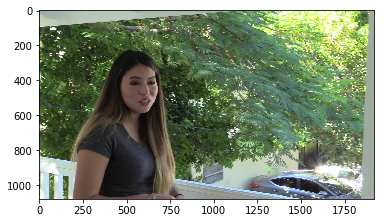

In [72]:
cap=cv2.VideoCapture(video)
ret,frame=cap.read()
frame=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
plt.imshow(frame)

# Define Helper Fuctions

In [73]:
def get_mtcnn_face(img):
    start=time.time()
    bboxes=mtcnn.detect_faces(frame)[0]['box']
    #print(bboxes)
    x,y,w,h=bboxes
    #是找到框左上角的点
    bboxes=x,x+w,y,y+h
    return time.time()-start, bboxes
def get_blazeface_face(img):
    start=time.time()
    #归一化，增加泛化能力
    scale_w = img.shape[1] / 128.0 
    scale_h = img.shape[0] / 128.0
    blaze_output=blazeface.predict_on_image(cv2.resize(frame, (128,128)))
    blaze_bboxes=scale_boxes(get_blaze_boxes(blaze_output), scale_w, scale_h)
    if blaze_bboxes==[]:
        return time.time()-start,[]
    lx, ly, rx, ry = blaze_bboxes[0]
    bboxes=int(lx), int(rx), int(ly), int(ry)
    return time.time()-start, bboxes
def get_mobilenet_face(image):
    start=time.time()
    global boxes,scores,num_detections
    #print(image.shape[:-1]) 打印image高和宽 
    (im_height,im_width)=image.shape[:-1]
    imgs=np.array([image])
    (boxes, scores) = sess.run(
        [boxes_tensor, scores_tensor],
        feed_dict={image_tensor: imgs})
    max_=np.where(scores==scores.max())[0][0]
    box=boxes[0][max_]
    ymin, xmin, ymax, xmax = box
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
    left, right, top, bottom = int(left), int(right), int(top), int(bottom)
    return time.time()-start,(left, right, top, bottom)
def get_yolo_face(image):
    start=time.time()
    bbox=yolo_model.detect(frame, 0.7)
    print(bbox)
    bbox=get_boxes_points(bbox,frame.shape)[0]
    #print(bbox)
    return time.time()-start,bbox

In [74]:
def annotate_image(frame,bbox,color):
    if bbox==[]:
        return frame
    frame=frame.copy()
    return cv2.rectangle(frame,(bbox[0],bbox[2]),(bbox[1],bbox[3]),color,10)
def crop_image(frame,bbox):
    left, right, top, bottom=bbox
    return frame[top:bottom,left:right]

### Warm up

In [75]:
_=get_blazeface_face(frame)
_=get_mtcnn_face(frame)
_=get_mobilenet_face(frame)
_=get_yolo_face(frame)

[[0.24818264323702854, 0.28716627181942267, 0.35266308050938516, 0.5383083245487063]]


# Speed Comparison

In [76]:
blaze_time,blaze_bboxes=get_blazeface_face(frame)
mtcnn_time,mtcnn_bboxes=get_mtcnn_face(frame)
mobilenet_time,mobilenet_bboxes=get_mobilenet_face(frame)
yolo_time,yolo_bboxes=get_yolo_face(frame)

[[0.24818264323702854, 0.28716627181942267, 0.35266308050938516, 0.5383083245487063]]


In [77]:
print("MTCNN Detection Time:"+str(mtcnn_time))
print("Yolo Detection Time:"+str(yolo_time))
print("Mobilenet Detection Time:"+str(mobilenet_time))
print("BlazeFace Detection Time:"+str(blaze_time))

MTCNN Detection Time:0.28405094146728516
Yolo Detection Time:0.048537492752075195
Mobilenet Detection Time:0.015913963317871094
BlazeFace Detection Time:0.025687456130981445


In [78]:
print('Mobilenet is '+str(mtcnn_time/mobilenet_time)+'times faster than MTCNN')
print('Blazeface is '+str(mobilenet_time/blaze_time)+'times faster than Mobilenet')
print('Mobilenet is '+str(yolo_time/mobilenet_time)+'times faster than YOLO')

Mobilenet is 17.849164019895728times faster than MTCNN
Blazeface is 0.6195227443591577times faster than Mobilenet
Mobilenet is 3.0499940073110805times faster than YOLO


# Ability to Detect Face

In [79]:
if blaze_bboxes==[]:
    print('⚠️BlazeFace is unable to detect face in this frame.')
if mtcnn_bboxes==[]:
    print('⚠️MTCNN is unable to detect face in this frame.')
if mobilenet_bboxes==[]:
    print('⚠️mobilenet is unable to detect face in this frame.')
if yolo_bboxes==[]:
    print('⚠️mobilenet is unable to detect face in this frame.')

# Accuracy Comparison

## Annotated Images

In [80]:
annotated=annotate_image(frame,mobilenet_bboxes,(255,0,0))
annotated=annotate_image(annotated,mtcnn_bboxes,(0,255,0))
annotated=annotate_image(annotated,blaze_bboxes,(0,0,255))
annotated=annotate_image(annotated,yolo_bboxes,(255,0,255))

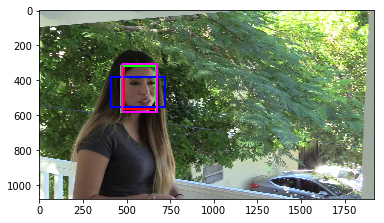

In [81]:
plt.imshow(annotated)

### Color Key:
* Blue: BlazeFace
* Red: Mobilenet
* Green: MTCNN
* Purple: YOLO

## Cropped Images

### BlazeFace

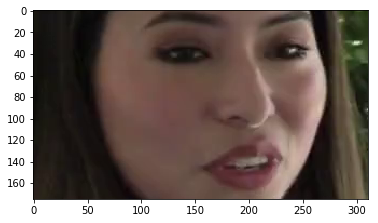

In [82]:
plt.imshow(crop_image(frame,blaze_bboxes))

### MTCNN

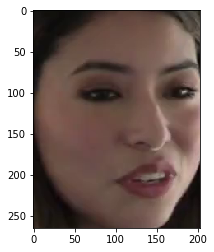

In [83]:
plt.imshow(crop_image(frame,mtcnn_bboxes))

### Mobilenet

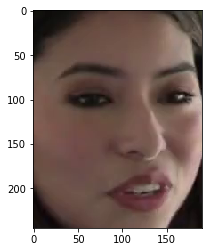

In [84]:
plt.imshow(crop_image(frame,mobilenet_bboxes))

### YOLO

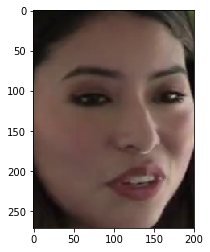

In [85]:
plt.imshow(crop_image(frame,yolo_bboxes))

# Extra Comparisons

[[0.42656755858315853, 0.07952249250471939, 0.52010016442524, 0.2937432125027618]]
MTCNN Detection Time:0.2801167964935303
Yolo Detection Time:0.04796195030212402
Mobilenet Detection Time:0.015720367431640625
BlazeFace Detection Time:0.021867036819458008
Mobilenet is 17.818718150934238times faster than MTCNN
Blazeface is 0.7189070728436386times faster than Mobilenet
Mobilenet is 3.0509433389953893times faster than YOLO


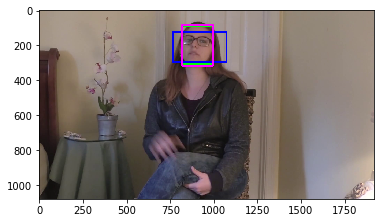

In [86]:
video='../input/deepfake-detection-challenge/train_sample_videos/eqnoqyfquo.mp4'
cap=cv2.VideoCapture(video)    
ret,frame=cap.read()
frame=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
blaze_time,blaze_bboxes=get_blazeface_face(frame)
mtcnn_time,mtcnn_bboxes=get_mtcnn_face(frame)
mobilenet_time,mobilenet_bboxes=get_mobilenet_face(frame)
yolo_time,yolo_bboxes=get_yolo_face(frame)  
print("MTCNN Detection Time:"+str(mtcnn_time))
print("Yolo Detection Time:"+str(yolo_time))
print("Mobilenet Detection Time:"+str(mobilenet_time))
print("BlazeFace Detection Time:"+str(blaze_time))
print('Mobilenet is '+str(mtcnn_time/mobilenet_time)+'times faster than MTCNN')
print('Blazeface is '+str(mobilenet_time/blaze_time)+'times faster than Mobilenet')
print('Mobilenet is '+str(yolo_time/mobilenet_time)+'times faster than YOLO')
if blaze_bboxes==[]:
    print('⚠️BlazeFace is unable to detect face in this frame.')
if mtcnn_bboxes==[]:
    print('⚠️MTCNN is unable to detect face in this frame.')
if mobilenet_bboxes==[]:
    print('⚠️mobilenet is unable to detect face in this frame.')
if yolo_bboxes==[]:
    print('⚠️mobilenet is unable to detect face in this frame.')
annotated=annotate_image(frame,mobilenet_bboxes,(255,0,0))
annotated=annotate_image(annotated,mtcnn_bboxes,(0,255,0))
annotated=annotate_image(annotated,blaze_bboxes,(0,0,255))
annotated=annotate_image(annotated,yolo_bboxes,(255,0,255))
plt.imshow(annotated)

[[0.4498745422181517, 0.06705843111215658, 0.5150739629638263, 0.2159403686498611]]
MTCNN Detection Time:0.4389023780822754
Yolo Detection Time:0.05039858818054199
Mobilenet Detection Time:0.016127586364746094
BlazeFace Detection Time:0.01924896240234375
Mobilenet is 27.214387085329076times faster than MTCNN
Blazeface is 0.8378418549346016times faster than Mobilenet
Mobilenet is 3.1249926083614215times faster than YOLO
⚠️BlazeFace is unable to detect face in this frame.


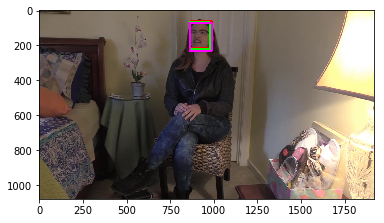

In [87]:
video='../input/deepfake-detection-challenge/train_sample_videos/eqjscdagiv.mp4'
cap=cv2.VideoCapture(video)    
ret,frame=cap.read()
frame=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
blaze_time,blaze_bboxes=get_blazeface_face(frame)
mtcnn_time,mtcnn_bboxes=get_mtcnn_face(frame)
mobilenet_time,mobilenet_bboxes=get_mobilenet_face(frame)
yolo_time,yolo_bboxes=get_yolo_face(frame)  
print("MTCNN Detection Time:"+str(mtcnn_time))
print("Yolo Detection Time:"+str(yolo_time))
print("Mobilenet Detection Time:"+str(mobilenet_time))
print("BlazeFace Detection Time:"+str(blaze_time))
print('Mobilenet is '+str(mtcnn_time/mobilenet_time)+'times faster than MTCNN')
print('Blazeface is '+str(mobilenet_time/blaze_time)+'times faster than Mobilenet')
print('Mobilenet is '+str(yolo_time/mobilenet_time)+'times faster than YOLO')
if blaze_bboxes==[]:
    print('⚠️BlazeFace is unable to detect face in this frame.')
if mtcnn_bboxes==[]:
    print('⚠️MTCNN is unable to detect face in this frame.')
if mobilenet_bboxes==[]:
    print('⚠️mobilenet is unable to detect face in this frame.')
if yolo_bboxes==[]:
    print('⚠️mobilenet is unable to detect face in this frame.')
annotated=annotate_image(frame,mobilenet_bboxes,(255,0,0))
annotated=annotate_image(annotated,mtcnn_bboxes,(0,255,0))
annotated=annotate_image(annotated,blaze_bboxes,(0,0,255))
annotated=annotate_image(annotated,yolo_bboxes,(255,0,255))
plt.imshow(annotated)

[[0.5496210300208496, 0.15327717613141018, 0.5964376599860934, 0.261170158553925]]
MTCNN Detection Time:0.3045632839202881
Yolo Detection Time:0.04892134666442871
Mobilenet Detection Time:0.015283584594726562
BlazeFace Detection Time:0.020832300186157227
Mobilenet is 19.92747722451017times faster than MTCNN
Blazeface is 0.7336484429540955times faster than Mobilenet
Mobilenet is 3.2009078996630476times faster than YOLO
⚠️BlazeFace is unable to detect face in this frame.


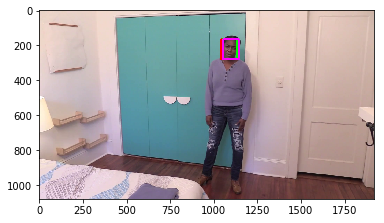

In [88]:
video='../input/deepfake-detection-challenge/train_sample_videos/emgjphonqb.mp4'
cap=cv2.VideoCapture(video)    
ret,frame=cap.read()
frame=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
blaze_time,blaze_bboxes=get_blazeface_face(frame)
mtcnn_time,mtcnn_bboxes=get_mtcnn_face(frame)
mobilenet_time,mobilenet_bboxes=get_mobilenet_face(frame)
yolo_time,yolo_bboxes=get_yolo_face(frame)  
print("MTCNN Detection Time:"+str(mtcnn_time))
print("Yolo Detection Time:"+str(yolo_time))
print("Mobilenet Detection Time:"+str(mobilenet_time))
print("BlazeFace Detection Time:"+str(blaze_time))
print('Mobilenet is '+str(mtcnn_time/mobilenet_time)+'times faster than MTCNN')
print('Blazeface is '+str(mobilenet_time/blaze_time)+'times faster than Mobilenet')
print('Mobilenet is '+str(yolo_time/mobilenet_time)+'times faster than YOLO')
if blaze_bboxes==[]:
    print('⚠️BlazeFace is unable to detect face in this frame.')
if mtcnn_bboxes==[]:
    print('⚠️MTCNN is unable to detect face in this frame.')
if mobilenet_bboxes==[]:
    print('⚠️mobilenet is unable to detect face in this frame.')
if yolo_bboxes==[]:
    print('⚠️mobilenet is unable to detect face in this frame.')
annotated=annotate_image(frame,mobilenet_bboxes,(255,0,0))
annotated=annotate_image(annotated,mtcnn_bboxes,(0,255,0))
annotated=annotate_image(annotated,blaze_bboxes,(0,0,255))
annotated=annotate_image(annotated,yolo_bboxes,(255,0,255))
plt.imshow(annotated)

[[0.44417515250868944, 0.1408191968780848, 0.5076495160374273, 0.30961911213728555]]
MTCNN Detection Time:0.2899808883666992
Yolo Detection Time:0.05008530616760254
Mobilenet Detection Time:0.01750493049621582
BlazeFace Detection Time:0.02049565315246582
Mobilenet is 16.565669222701953times faster than MTCNN
Blazeface is 0.8540801488978073times faster than Mobilenet
Mobilenet is 2.8612113700439927times faster than YOLO
⚠️BlazeFace is unable to detect face in this frame.


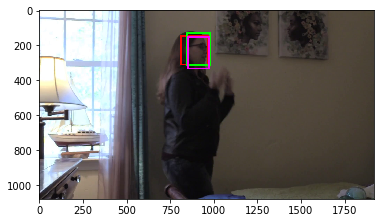

In [89]:
video='../input/deepfake-detection-challenge/train_sample_videos/cffffbcywc.mp4'
cap=cv2.VideoCapture(video)    
ret,frame=cap.read()
frame=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
blaze_time,blaze_bboxes=get_blazeface_face(frame)
mtcnn_time,mtcnn_bboxes=get_mtcnn_face(frame)
mobilenet_time,mobilenet_bboxes=get_mobilenet_face(frame)
yolo_time,yolo_bboxes=get_yolo_face(frame)  
print("MTCNN Detection Time:"+str(mtcnn_time))
print("Yolo Detection Time:"+str(yolo_time))
print("Mobilenet Detection Time:"+str(mobilenet_time))
print("BlazeFace Detection Time:"+str(blaze_time))
print('Mobilenet is '+str(mtcnn_time/mobilenet_time)+'times faster than MTCNN')
print('Blazeface is '+str(mobilenet_time/blaze_time)+'times faster than Mobilenet')
print('Mobilenet is '+str(yolo_time/mobilenet_time)+'times faster than YOLO')
if blaze_bboxes==[]:
    print('⚠️BlazeFace is unable to detect face in this frame.')
if mtcnn_bboxes==[]:
    print('⚠️MTCNN is unable to detect face in this frame.')
if mobilenet_bboxes==[]:
    print('⚠️mobilenet is unable to detect face in this frame.')
if yolo_bboxes==[]:
    print('⚠️mobilenet is unable to detect face in this frame.')
annotated=annotate_image(frame,mobilenet_bboxes,(255,0,0))
annotated=annotate_image(annotated,mtcnn_bboxes,(0,255,0))
annotated=annotate_image(annotated,blaze_bboxes,(0,0,255))
annotated=annotate_image(annotated,yolo_bboxes,(255,0,255))
plt.imshow(annotated)

[[0.5307509785165422, 0.0870933510063667, 0.6240946121326806, 0.31372244221335355]]
MTCNN Detection Time:0.27985262870788574
Yolo Detection Time:0.0494532585144043
Mobilenet Detection Time:0.015561103820800781
BlazeFace Detection Time:0.019432783126831055
Mobilenet is 17.98411166268309times faster than MTCNN
Blazeface is 0.8007655784165777times faster than Mobilenet
Mobilenet is 3.1780045351473922times faster than YOLO
⚠️BlazeFace is unable to detect face in this frame.


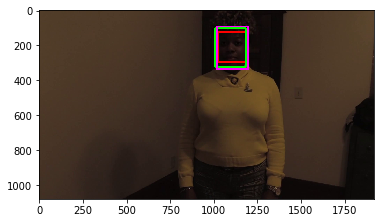

In [90]:
video='../input/deepfake-detection-challenge/train_sample_videos/byfenovjnf.mp4'
cap=cv2.VideoCapture(video)    
ret,frame=cap.read()
frame=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
blaze_time,blaze_bboxes=get_blazeface_face(frame)
mtcnn_time,mtcnn_bboxes=get_mtcnn_face(frame)
mobilenet_time,mobilenet_bboxes=get_mobilenet_face(frame)
yolo_time,yolo_bboxes=get_yolo_face(frame)  
print("MTCNN Detection Time:"+str(mtcnn_time))
print("Yolo Detection Time:"+str(yolo_time))
print("Mobilenet Detection Time:"+str(mobilenet_time))
print("BlazeFace Detection Time:"+str(blaze_time))
print('Mobilenet is '+str(mtcnn_time/mobilenet_time)+'times faster than MTCNN')
print('Blazeface is '+str(mobilenet_time/blaze_time)+'times faster than Mobilenet')
print('Mobilenet is '+str(yolo_time/mobilenet_time)+'times faster than YOLO')
if blaze_bboxes==[]:
    print('⚠️BlazeFace is unable to detect face in this frame.')
if mtcnn_bboxes==[]:
    print('⚠️MTCNN is unable to detect face in this frame.')
if mobilenet_bboxes==[]:
    print('⚠️mobilenet is unable to detect face in this frame.')
if yolo_bboxes==[]:
    print('⚠️mobilenet is unable to detect face in this frame.')
annotated=annotate_image(frame,mobilenet_bboxes,(255,0,0))
annotated=annotate_image(annotated,mtcnn_bboxes,(0,255,0))
annotated=annotate_image(annotated,blaze_bboxes,(0,0,255))
annotated=annotate_image(annotated,yolo_bboxes,(255,0,255))
plt.imshow(annotated)

# Conclusion

After all, blaze face is indeed fast similar to mobilenet.but not that accurate and also can't detect face. mobilenet face have very close results to MTCNN/YOLO but faster.